# Some EDA

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Energy = pd.read_csv('../../data/energy_dataset.csv')
Temps = pd.read_csv('AllTemps.csv', skipinitialspace=True)

print(list(Energy.keys()))
print(list(Temps.keys()))
print(Temps.shape)
print(Energy.shape)

['time', 'generation biomass', 'generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage aggregated', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation marine', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind offshore', 'generation wind onshore', 'forecast solar day ahead', 'forecast wind offshore eday ahead', 'forecast wind onshore day ahead', 'total load forecast', 'total load actual', 'price day ahead', 'price actual']
['Unnamed: 0', 'time', 'tempV', 'tempM', 'tempBi', 'tempBa', 'tempS']
(35064, 7)
(35064, 29)


Made sure that both dataframes are shaped the same

## Get Avg Temp

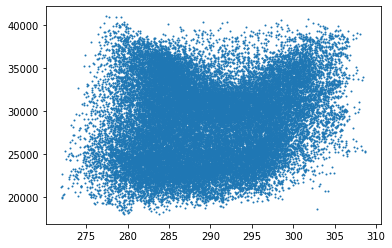

In [46]:
TempsAverage = []
for index, row in Temps.iterrows():
    TempsAverage.append(np.mean([row['tempV'], row['tempM'], row['tempBi'], row['tempBa'], row['tempS']]))

TempsAverage = pd.DataFrame({
    "time": list(Temps['time']),
    "tAve": TempsAverage
})
plt.scatter(TempsAverage['tAve'], Energy['total load actual'], s=1)
plt.show()

Pretty cool stuff! Marked minimum of total load at ~=71F. After this value, there is a strong upward correlation in temperature, but below, when people would be using heaters, there is some more interesting stuff going on. Maybe look at nighttime vs daytime? Will have to do some string manip.

### Neural Network LOL